Mounted at /content/drive
Using device: cuda
Loaded existing CSV with 3302 rows
Tokenizer size: 30000
Loading pre-trained weights from: /content/drive/MyDrive/email_bert/bert_email_epoch_19.pth
✓ Loaded weights.


Epoch 1/3: 100%|██████████| 186/186 [00:10<00:00, 18.20it/s]


Epoch 1: avg train loss = 0.6090


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 20.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Epoch 1: Test Accuracy = 0.8489
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       281
         1.0       0.00      0.00      0.00        50

    accuracy                           0.85       331
   macro avg       0.42      0.50      0.46       331
weighted avg       0.72      0.85      0.78       331



Epoch 2/3: 100%|██████████| 186/186 [00:09<00:00, 19.34it/s]


Epoch 2: avg train loss = 0.5044


Evaluating: 100%|██████████| 21/21 [00:00<00:00, 21.13it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Epoch 2: Test Accuracy = 0.8489
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       281
         1.0       0.00      0.00      0.00        50

    accuracy                           0.85       331
   macro avg       0.42      0.50      0.46       331
weighted avg       0.72      0.85      0.78       331



Epoch 3/3: 100%|██████████| 186/186 [00:09<00:00, 19.65it/s]


Epoch 3: avg train loss = 0.4365


Evaluating: 100%|██████████| 21/21 [00:00<00:00, 21.40it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Epoch 3: Test Accuracy = 0.8489
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       281
         1.0       0.00      0.00      0.00        50

    accuracy                           0.85       331
   macro avg       0.42      0.50      0.46       331
weighted avg       0.72      0.85      0.78       331

Confusion matrix:
 [[281   0]
 [ 50   0]]
Saved confusion matrix to /content/drive/MyDrive/email_bert/confusion_matrix_spam.png
Saved spam classifier to /content/drive/MyDrive/email_bert/spam_classifier_bert_small.pth


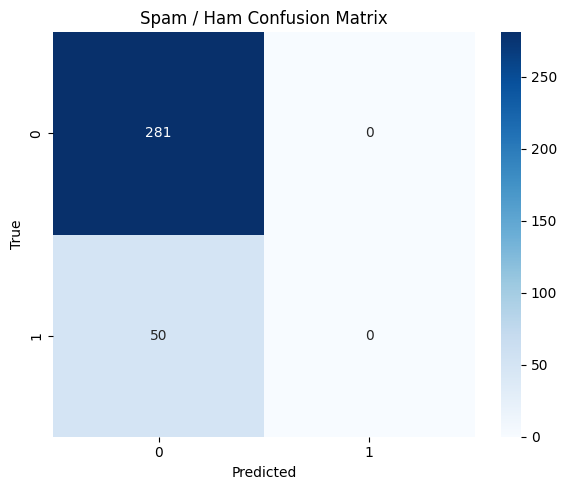

In [1]:
import os
import requests
import tarfile
import email
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import BertTokenizerFast

# ========= PATHS =========
BASE_DIR = "/content/drive/MyDrive/email_bert"
SPAMASSASSIN_DIR = os.path.join(BASE_DIR, "datasets", "spamassassin")
MODEL_PATH = os.path.join(BASE_DIR, "bert_email_epoch_19.pth")  # your pre-trained BERTSmall
TOKENIZER_PATH = os.path.join(BASE_DIR, "tokenizer", "bert-email-vocab.txt")

# ========= DRIVE MOUNT =========
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.makedirs(SPAMASSASSIN_DIR, exist_ok=True)

# ========= PART 1: DOWNLOAD + PROCESS SPAMASSASSIN =========
def download_spamassassin():
    """Download and extract SpamAssassin corpus into Drive."""
    urls = [
        'https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2',
        'https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2',
        'https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2'
    ]

    for url in urls:
        filename = url.split('/')[-1]        # <-- FIXED (removed stray 'i')
        filepath = os.path.join(SPAMASSASSIN_DIR, filename)

        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            resp = requests.get(url, stream=True)
            with open(filepath, "wb") as f:
                for chunk in tqdm(resp.iter_content(chunk_size=1024)):
                    if chunk:
                        f.write(chunk)

        print(f"Extracting {filename}...")
        with tarfile.open(filepath, "r:bz2") as tar:
            tar.extractall(SPAMASSASSIN_DIR)

        # Remove archive to save space
        os.remove(filepath)


def process_spamassassin():
    """Process extracted emails into a DataFrame with columns: text, label."""
    print("Processing emails...")
    texts, labels = [], []

    # Helper: extract body from an email message
    def extract_body(msg):
        body = ""
        if msg.is_multipart():
            for part in msg.walk():
                ctype = part.get_content_type()
                if ctype in ("text/plain", "text/html"):
                    payload = part.get_payload(decode=True)
                    if payload:
                        body += payload.decode("latin-1", errors="ignore")
        else:
            payload = msg.get_payload(decode=True)
            if payload:
                body = payload.decode("latin-1", errors="ignore")
        return body

    # Ham dirs
    for ham_dir in ["easy_ham", "hard_ham"]:
        dir_path = os.path.join(SPAMASSASSIN_DIR, ham_dir)
        if os.path.exists(dir_path):
            for fname in tqdm(os.listdir(dir_path), desc=f"Reading {ham_dir}"):
                if fname == "cmds":
                    continue
                fpath = os.path.join(dir_path, fname)
                try:
                    with open(fpath, "r", encoding="latin-1") as f:
                        content = f.read()
                    msg = email.message_from_string(content)
                    body = extract_body(msg)
                    texts.append(body)
                    labels.append(0)  # ham
                except Exception as e:
                    print(f"Error with {fpath}: {e}")

    # Spam dir
    spam_dir = os.path.join(SPAMASSASSIN_DIR, "spam")
    if os.path.exists(spam_dir):
        for fname in tqdm(os.listdir(spam_dir), desc="Reading spam"):
            if fname == "cmds":
                continue
            fpath = os.path.join(spam_dir, fname)
            try:
                with open(fpath, "r", encoding="latin-1") as f:
                    content = f.read()
                msg = email.message_from_string(content)
                body = extract_body(msg)
                texts.append(body)
                labels.append(1)  # spam
            except Exception as e:
                print(f"Error with {fpath}: {e}")

    df = pd.DataFrame({"text": texts, "label": labels})
    out_csv = os.path.join(SPAMASSASSIN_DIR, "spamassassin.csv")
    df.to_csv(out_csv, index=False)
    print(f"Dataset created with {len(df)} emails")
    print("Ham:", (df["label"] == 0).sum(), "Spam:", (df["label"] == 1).sum())
    return df

# ========= BERTSmall (same as your pretraining, but with return_hidden option) =========
class BERTSmall(nn.Module):
    def __init__(self, vocab, d_model=512, layers=8, heads=8, seq_len=64):
        super().__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(vocab, d_model)
        self.pos = nn.Embedding(seq_len, d_model)
        self.seg = nn.Embedding(2, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=heads,
            dim_feedforward=d_model * 3,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)

        # heads used during pretraining (we keep them so checkpoint loads)
        self.mlm = nn.Linear(d_model, vocab)
        self.nsp = nn.Linear(d_model, 2)

    def forward(self, ids, seg, return_hidden=False):
        b, L = ids.shape
        pos = torch.arange(L, device=ids.device).unsqueeze(0)
        x = self.emb(ids) + self.pos(pos) + self.seg(seg)
        x = self.encoder(x)

        if return_hidden:
            return x  # (B, L, d_model)

        mlm_logits = self.mlm(x)
        nsp_logits = self.nsp(x[:, 0])
        return mlm_logits, nsp_logits

# ========= Dataset for spam classification =========
class SpamEmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tok(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        token_type_ids = enc["token_type_ids"].squeeze(0)

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "labels": torch.tensor(label, dtype=torch.float),
        }

# ========= Classifier on top of BERTSmall =========
class BERTSmallSpamClassifier(nn.Module):
    def __init__(self, bert_backbone: BERTSmall):
        super().__init__()
        self.bert = bert_backbone
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(512, 1)  # 512 because d_model=512

    def forward(self, input_ids, token_type_ids):
        # get hidden states from BERTSmall
        hidden = self.bert(input_ids, token_type_ids, return_hidden=True)
        cls_repr = hidden[:, 0]  # [CLS] token
        x = self.dropout(cls_repr)
        logits = self.classifier(x)
        return logits

# ========= MAIN =========
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 1) Load / build dataset
    csv_path = os.path.join(SPAMASSASSIN_DIR, "spamassassin.csv")
    if not os.path.exists(csv_path):
        download_spamassassin()
        df = process_spamassassin()
    else:
        df = pd.read_csv(csv_path)
        print("Loaded existing CSV with", len(df), "rows")

    # Clean text a bit
    import re
    def clean_text(t):
        t = re.sub(r"<.*?>", "", str(t))
        t = re.sub(r"http\S+", "", t)
        t = re.sub(r"\S+@\S+", "", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t

    df["text"] = df["text"].apply(clean_text)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], test_size=0.1, random_state=42, stratify=df["label"]
    )

    # 2) Load your tokenizer
    tokenizer = BertTokenizerFast(
        vocab_file=TOKENIZER_PATH,
        lowercase=True,
        strip_accents=False
    )
    print("Tokenizer size:", len(tokenizer))

    MAX_LEN = 64
    train_dataset = SpamEmailDataset(X_train.values, y_train.values, tokenizer, MAX_LEN)
    test_dataset = SpamEmailDataset(X_test.values, y_test.values, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # 3) Build BERTSmall and load your pre-trained weights
    vocab_size = len(tokenizer)
    bert_small = BERTSmall(vocab=vocab_size)

    print("Loading pre-trained weights from:", MODEL_PATH)
    state = torch.load(MODEL_PATH, map_location="cpu")
    bert_small.load_state_dict(state)
    print("✓ Loaded weights.")

    # 4) Wrap with classifier
    model = BERTSmallSpamClassifier(bert_small).to(device)

    # 5) Training setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # 6) Train
    epochs = 3
    for ep in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, token_type_ids).squeeze(-1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {ep+1}: avg train loss = {avg_loss:.4f}")

        # Evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids = batch["input_ids"].to(device)
                token_type_ids = batch["token_type_ids"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids, token_type_ids).squeeze(-1)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        y_true_np = np.array(y_true)
        y_pred_np = np.array(y_pred)
        acc = (y_true_np == y_pred_np).mean()
        print(f"Epoch {ep+1}: Test Accuracy = {acc:.4f}")
        print(classification_report(y_true_np, y_pred_np))

    # 7) Final eval + confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("Confusion matrix:\n", cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Spam / Ham Confusion Matrix")
    plt.tight_layout()
    cm_path = os.path.join(BASE_DIR, "confusion_matrix_spam.png")
    plt.savefig(cm_path)
    print("Saved confusion matrix to", cm_path)

    # 8) Save classifier
    out_model_path = os.path.join(BASE_DIR, "spam_classifier_bert_small.pth")
    torch.save(model.state_dict(), out_model_path)
    print("Saved spam classifier to", out_model_path)

if __name__ == "__main__":
    main()
